In [ ]:
!pip install attrdict deepdish pyro-ppl uncertainty-calibration

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm.auto import tqdm
import torch
from sklearn.model_selection import train_test_split
import csv
import numpy as np
import os

In [ ]:
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [ ]:
from torch import nn, optim
from torch.distributions.log_normal import LogNormal
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from torch.nn.functional import softmax

In [ ]:
import numpy as np
from scipy import optimize
from sklearn.isotonic import IsotonicRegression

In [ ]:
from attrdict import AttrDict
from sklearn.cluster import KMeans 

In [ ]:
class TSCalibrator():
    """ Maximum likelihood temperature scaling (Guo et al., 2017)
    """

    def __init__(self, temperature=1., n_clusters=14):
        super().__init__()
        self.temperature = []
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=0)

        self.loss_trace = None

    def fitHelper(self, logits, y, cluster):
        """ Fits temperature scaling using hard labels.
        """
        # Pre-processing
        self.n_classes = logits.shape[1]
        _model_logits = torch.from_numpy(logits)
        _y = torch.from_numpy(y)
        _temperature = torch.tensor(self.temperature[cluster], requires_grad=True)

        # Optimization parameters
        nll = nn.CrossEntropyLoss()  # Supervised hard-label loss
        num_steps = 7500
        learning_rate = 0.05
        grad_tol = 1e-3  # Gradient tolerance for early stopping
        min_temp, max_temp = 1e-2, 1e4  # Upper / lower bounds on temperature

        optimizer = optim.Adam([_temperature], lr=learning_rate)

        loss_trace = []  # Track loss over iterations
        step = 0
        converged = False
        while not converged:

            optimizer.zero_grad()
            loss = nll(_model_logits / _temperature, _y)
            loss.backward()
            optimizer.step()
            loss_trace.append(loss.item())

            with torch.no_grad():
                _temperature.clamp_(min=min_temp, max=max_temp)

            step += 1
            if step > num_steps:
                warnings.warn('Maximum number of steps reached -- may not have converged (TS)')
            converged = (step > num_steps) or (np.abs(_temperature.grad) < grad_tol)

        self.loss_trace = loss_trace
        # self.temperature = _temperature.item()
        return _temperature.item()

    def fit(self, model_logits, y_true):
        self.kmeans.fit(model_logits)

        _model_logits = []
        _y_true = []
        for _ in range(self.n_clusters):
            _model_logits.append([])
            _y_true.append([])
            self.temperature.append(1.0)

        for i in range(self.kmeans.labels_.shape[0]):
            cluster_center = self.kmeans.labels_[i]
            _model_logits[cluster_center].append(model_logits[i])
            _y_true[cluster_center].append(y_true[i])

        for cluster in range(0, self.n_clusters):
            self.temperature[cluster] = self.fitHelper(np.array(_model_logits[cluster]), np.array(_y_true[cluster]), cluster)

    def calibrate(self, probs):
        clipped_model_probs = np.clip(probs, 1e-50, 1)
        model_logits = np.log(clipped_model_probs)
        labels = self.kmeans.predict(model_logits)

        for i in range(model_logits.shape[0]):
            probs[i] = probs[i] ** (1. / self.temperature[labels[i]])

        # calibrated_probs = probs ** (1. / self.temperature)  # Temper
        probs /= np.sum(probs, axis=1, keepdims=True)  # Normalize
        return probs

In [ ]:
class OracleCombiner:
    """ Implements the P+L combination method, fit using maximum likelihood
    """
    def __init__(self, calibration_method='temperature scaling', **kwargs):
        self.calibrator = None
        self.confusion_matrix = None  # conf[i, j] is assumed to be P(h = i | Y = j)

        self.n_train_u = None  # Amount of unlabeled training data
        self.n_train_l = None  # Amount of labeled training data
        self.n_cls = None  # Number of classes

        self.eps = 1e-50

        self.use_cv = False
        self.calibration_method = calibration_method
        self.calibrator = TSCalibrator()

    def calibrate(self, model_probs):
        return self.calibrator.calibrate(model_probs)

    def fit(self, model_probs, y_h, y_true):
        self.n_cls = model_probs.shape[1]

        # Estimate human confusion matrix
        # Entry [i, j]  is #(Y = i and h = j)
        conf_h = 1. * confusion_matrix(y_true, y_h, labels=np.arange(self.n_cls))
        # Swap so entry [i, j] is #(h = i and Y = j)
        conf_h = conf_h.T
        conf_h = np.clip(conf_h, self.eps, None)
        normalizer = np.sum(conf_h, axis=0, keepdims=True)
        # Normalize columns so entry [i, j] is P(h = i | Y = j)
        conf_h /= normalizer
        self.confusion_matrix = conf_h

        # Calibrate model probabilities
        if self.use_cv:
            self.fit_calibrator_cv(model_probs, y_true)
        else:
            self.fit_calibrator(model_probs, y_true)

    def fit_bayesian(self, model_probs, y_h, y_true, alpha=0.1, beta=0.1):
        """ This is the "plus one" parameterization, i.e. alpha,beta just need to be > 0
        Really corresponds to a Dirichlet(alpha+1, beta+1, beta+1, . . . ,beta+1) distribution
        """
        self.n_cls = model_probs.shape[1]

        prior_matr = np.eye(self.n_cls) * alpha + (np.ones(self.n_cls) - np.eye(self.n_cls)) * beta

        conf_h = 1. * confusion_matrix(y_true, y_h, labels=np.arange(self.n_cls))
        conf_h += prior_matr
        # Swap so entry [i, j] is #(h = i and Y = j)
        conf_h = conf_h.T
        #conf_h = np.clip(conf_h, self.eps, None)
        normalizer = np.sum(conf_h, axis=0, keepdims=True)
        # Normalize columns so entry [i, j] is P(h = i | Y = j)
        conf_h = conf_h / normalizer
        self.confusion_matrix = conf_h

        # Calibrate model probabilities
        if self.use_cv:
            self.fit_calibrator_cv(model_probs, y_true)
        else:
            self.fit_calibrator(model_probs, y_true)

    def fit_calibrator(self, model_probs, y_true):
        clipped_model_probs = np.clip(model_probs, self.eps, 1)
        model_logits = np.log(clipped_model_probs)
        self.calibrator.fit(model_logits, y_true)

    def fit_calibrator_cv(self, model_probs, y_true):
        # Fits calibration maps that require hyperparameters, using cross-validation
        if self.calibration_method == 'dirichlet':
            reg_lambda_vals = [10., 1., 0., 5e-1, 1e-1, 1e-2, 1e-3]
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
            gscv = GridSearchCV(self.calibrator, param_grid={'reg_lambda': reg_lambda_vals,
                                                             'reg_mu': [None]},
                                cv=skf, scoring='neg_log_loss', refit=True)
            gscv.fit(model_probs, y_true)
            self.calibrator = gscv.best_estimator_
        else:
            raise NotImplementedError

    def combine_proba(self, model_probs, y_h, y_true_te, miss_cost = 9, human_cost = 1):
        """ Combines model probabilities with hard labels via the calibrate-confuse equation given the confusion matrix.

        Args:
            p_m: Array of model probabilities ; shape (n_samples, n_classes)
            y_h: List of hard labels ; shape (n_samples,)

        Returns:
            Normalized posterior probabilities P(Y | m, h). Entry [i, j] is P(Y = j | h_i, m_i)
        """
        assert model_probs.shape[0] == y_h.size, 'Size mismatch between model probs and human labels'
        assert model_probs.shape[1] == self.n_cls, 'Size mismatch between model probs and number of classes'

        n_samples = model_probs.shape[0]
        calibrated_model_probs = self.calibrate(model_probs)

        model_output = np.argmax(calibrated_model_probs, axis=1)
        
        # Accuracy Parameters
        human_correct = 0
        human_refered = 0
        model_correct = 0
        model_refered = 0
        
        y_comb = np.empty((n_samples, self.n_cls))
        for i in range(n_samples):

            P_X = miss_cost * (1 - calibrated_model_probs[i][model_output[i]])
            if(human_cost <= P_X):
                # y_comb[i] = calibrated_model_probs[i] * self.confusion_matrix[y_h[i]]
                y_comb[i] = calibrated_model_probs[i] * self.confusion_matrix[y_h[i]]
                human_refered += 1
                if(np.argmax(y_comb[i]) == y_true_te[i]):
                    human_correct += 1
            else:
                y_comb[i] = calibrated_model_probs[i]
                model_refered += 1
                if(np.argmax(y_comb[i]) == y_true_te[i]):
                    model_correct += 1

            if np.allclose(y_comb[i], 0):  # Handle zero rows
                y_comb[i] = np.ones(self.n_cls) * (1./self.n_cls)
        
        # fig, ax = plt.subplots(figsize=(10, 10))
        # ax.matshow(self.confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
        # for i in range(self.confusion_matrix.shape[0]):
        #     for j in range(self.confusion_matrix.shape[1]):
        #         t = round(self.confusion_matrix[i, j], 2)
        #         ax.text(x=j, y=i,s=t, va='center', ha='center', size='xx-large')
        
        # plt.xlabel('Predictions', fontsize=18)
        # plt.ylabel('Actuals', fontsize=18)
        # plt.title('Confusion Matrix', fontsize=18)
        # plt.show()

        result = {
            'Missclassification Cost' : miss_cost,
            'Human cost': human_cost,
            'Combined accuracy': (human_correct + model_correct) / n_samples,
            'Human correct': human_correct,
            'Human refered': human_refered,
            'Human accuracy': human_correct / human_refered,
            'Model correct': model_correct,
            'Model refered': model_refered,
            'Model accuracy': model_correct / model_refered,
            'Model cost': miss_cost * (model_refered - model_correct) + human_cost * human_refered
        }

        # Don't forget to normalize :)
        assert np.all(np.isfinite(np.sum(y_comb, axis=1)))
        assert np.all(np.sum(y_comb, axis=1) > 0)
        y_comb /= np.sum(y_comb, axis=1, keepdims=True)
        return y_comb, result
        # return calibrated_model_probs, self.confusion_matrix, y_comb

    def combine(self, model_probs, y_h, y_true_te, miss_cost = 9, human_cost = 1):
        """ Combines model probs and y_h to return hard labels
        """
        y_comb_soft, result = self.combine_proba(model_probs, y_h, y_true_te, miss_cost, human_cost)
        return np.argmax(y_comb_soft, axis=1), result

        # calibrated_model_probs, confusion_matrix, y_comb_soft = self.combine_proba(model_probs, y_h)
        # return calibrated_model_probs, confusion_matrix, y_comb_soft
        

In [ ]:
def get_acc(y_pred, y_true):
    """ Computes the accuracy of predictions.
    If y_pred is 2D, it is assumed that it is a matrix of scores (e.g. probabilities) of shape (n_samples, n_classes)
    """
    if y_pred.ndim == 1:
        return np.mean(y_pred == y_true)
    elif y_pred.ndim == 2:
        return np.mean(np.argmax(y_pred, axis=1), y_true)

In [ ]:
def load_CIFAR10H(model_name):
    """ Loads the CIFAR-10H predictions (human and model) and true labels.
    """
    if model_name == 'r_low_acc':
        data_path = 'cifar10h/human_model_truth_cifar10h.csv'
        data = np.genfromtxt(data_path, delimiter=',')

        human_counts = data[:, :10]
        model_probs = data[:, 10:20]
        true_labels = data[:, -1]

        true_labels -= 1  # data has labels 1-10 -- shifting so that they are zero-indexed.
    else:
        data_path = f'cifar10h/{model_name}.csv'
        data = np.genfromtxt(data_path, delimiter=',')

        true_labels = data[:, 0]
        human_counts = data[:, 1:11]
        model_probs = data[:, 11:]

    true_labels = true_labels.astype(int)

    return human_counts, model_probs, true_labels

In [ ]:
def simulate_single_human(human_counts, seed=0):
    rng = np.random.default_rng(seed)

    human_labels_per_input = np.sum(human_counts, axis=1)
    min_human_labels = int(min(human_labels_per_input))
    n_rows = human_counts.shape[0]
    n_classes = human_counts.shape[1]

    human_labels = np.empty(shape=(n_rows, min_human_labels))
    for row in range(n_rows):
        temp = []
        for i in range(n_classes):
            temp += [i] * int(human_counts[row, i])
        rng.shuffle(temp)
        human_labels[row, :] = temp[:min_human_labels]

    return human_labels[:, 0].astype(int)

In [ ]:
def _run_experiment(y_h=None, model_probs=None, y_true=None, **kwargs):
    seed = kwargs.pop('seed', 0)
    n_runs = kwargs.pop('n_runs', 25)
    test_size = kwargs.pop('test_size', 0.3)
    calibration_methods = kwargs.pop('calibration_methods', ['none'])
    output_file_acc = kwargs.pop('output_file_acc', './acc.csv')

    # classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # header_acc = ['human', 'model'] + classes

    miss_cost = 9
    human_cost = 1

    acc_data = []
    for i in tqdm(range(n_runs), leave=False, desc='Runs'):
        # Train/test split
        y_h_tr, y_h_te, model_probs_tr, model_probs_te, y_true_tr, y_true_te = train_test_split(
            y_h, model_probs, y_true, test_size=test_size, random_state=i * seed)

        acc_h = get_acc(y_h_te, y_true_te)
        acc_m = get_acc(np.argmax(model_probs_te, axis=1), y_true_te)

        _acc_data = [acc_h, acc_m]
        for calibration_method in calibration_methods:
            
            combiner = OracleCombiner(calibration_method=calibration_method)

            combiner.fit(model_probs_tr, y_h_tr, y_true_tr)

            y_comb_te, result = combiner.combine(model_probs_te, y_h_te, y_true_te, miss_cost, human_cost)
            acc_comb = get_acc(y_comb_te, y_true_te)
            _acc_data.append(acc_comb)
            _acc_data += list(result.values())

        acc_data += [_acc_data]

    # Save data to CSV
    header_acc = ['human', 'model'] + [f'comb {cal_m}' for cal_m in calibration_methods] + list(result.keys())
    with open(output_file_acc, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header_acc)
        writer.writerows(acc_data)

In [ ]:
def run_experiment_cifar10(out_fpath=None, experiment_args=None, seed=0):
    model_names = [
                   'r_low_acc', 
                  #  'resnet-110', 
                  #  'preresnet-110', 
                  #  'densenet-bc-L190-k40'
                   ]

    for model_name in tqdm(model_names, desc='Models', leave=True):
        # Specify output files
        output_file_acc = out_fpath + f'{model_name}_accuracy.csv'
        assert not os.path.exists(output_file_acc), 'Output filepath already exists'
        experiment_args['output_file_acc'] = output_file_acc

        # Load data
        human_counts, model_probs, y_true = load_CIFAR10H(model_name) # data_utils.py
        y_h = simulate_single_human(human_counts, seed=seed)

        # _run_experiment(y_h=y_h, model_probs=model_probs, y_true=y_true, **experiment_args)
        return model_probs, y_true, y_h

In [ ]:
seed = 9658
torch.manual_seed(seed)
np.random.seed(seed)

calibration_methods = [
    'temperature scaling'
    ]

args = {
    'n_runs': 1,
    'test_size': 0.3,
    'calibration_methods': calibration_methods,
    'seed': seed
        }


In [ ]:
# !git clone https://github.com/GavinKerrigan/conf_matrix_and_calibration.git
# !mv /content/conf_matrix_and_calibration/cifar10h .
# !rm -R /content/conf_matrix_and_calibration
# !mkdir output

In [ ]:
# !rm -R output
# !mkdir output

In [ ]:
out_fpath = './output/'
model_probs, y_true, y_h = run_experiment_cifar10(out_fpath=out_fpath, experiment_args=args, seed=seed)

Models:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
y_h, y_h_te, model_probs, model_probs_te, y_true, y_true_te = train_test_split(
            y_h, model_probs, y_true, test_size=0.3, random_state=1 * seed)

In [ ]:
y_h.shape

(7000,)

In [ ]:
def print_classwise_accuracy(y_val, Y_pred):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for label, prediction in zip(y_val, Y_pred):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} of size {total_pred[classname]} is {accuracy:.1f} %')

In [ ]:
# Classwise accuracy of human
print_classwise_accuracy(y_true, y_h)

Accuracy for class: plane of size 687 is 96.4 %
Accuracy for class: car   of size 724 is 98.2 %
Accuracy for class: bird  of size 706 is 95.5 %
Accuracy for class: cat   of size 695 is 90.6 %
Accuracy for class: deer  of size 711 is 90.6 %
Accuracy for class: dog   of size 687 is 94.5 %
Accuracy for class: frog  of size 693 is 95.4 %
Accuracy for class: horse of size 688 is 97.8 %
Accuracy for class: ship  of size 710 is 98.2 %
Accuracy for class: truck of size 699 is 97.9 %


In [ ]:
# classwise accuracy of model
print_classwise_accuracy(y_true, np.argmax(model_probs, axis=1))

Accuracy for class: plane of size 687 is 89.8 %
Accuracy for class: car   of size 724 is 95.0 %
Accuracy for class: bird  of size 706 is 86.8 %
Accuracy for class: cat   of size 695 is 75.1 %
Accuracy for class: deer  of size 711 is 90.3 %
Accuracy for class: dog   of size 687 is 83.8 %
Accuracy for class: frog  of size 693 is 92.1 %
Accuracy for class: horse of size 688 is 90.8 %
Accuracy for class: ship  of size 710 is 94.1 %
Accuracy for class: truck of size 699 is 92.7 %


In [ ]:
Y_model_pred = np.argmax(model_probs, axis=1)
cat_confidence = []
for i in range(Y_model_pred.shape[0]):
    if(Y_model_pred[i] == 3):
        cat_confidence.append(model_probs[i][3]*100)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# # Plot Histogram on x
# plt.hist(cat_confidence, bins=10)
# plt.gca().set(title='Machine learning model confidence distribution on 75% accuracy', xlabel='Machine learning model confidence', ylabel='Frequency');

In [ ]:
eps = 1e-50
k = 70
calibrator = TSCalibrator(n_clusters=k)
clipped_model_probs = np.clip(model_probs, eps, 1)
model_logits = np.log(clipped_model_probs)

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(model_logits)

In [ ]:
_model_logits = []
_model_probs = []
_y_h = []
_y_true = []
_T = []
_conf_h = []
# initialise
for _ in range(k):
    _model_logits.append([])
    _model_probs.append([])
    _y_h.append([])
    _y_true.append([])
    calibrator.temperature.append(1.0)
    _T.append(1)

In [ ]:
np.array(_y_true[0])
np.array(_y_h[0])

array([], dtype=float64)

In [ ]:
# group based on clusters    
for i in range(kmeans.labels_.shape[0]):
    cluster_center = kmeans.labels_[i]
    _model_logits[cluster_center].append(model_logits[i])
    _y_true[cluster_center].append(y_true[i])
    _model_probs[cluster_center].append(model_probs[i])
    _y_h[cluster_center].append(y_h[i])

# Calculater T corresponding to each cluster
for cluster in range(0, k):
    _T[cluster] = calibrator.fitHelper(np.array(_model_logits[cluster]), np.array(_y_true[cluster]), cluster)
    
    conf_h = 1. * confusion_matrix(np.array(_y_true[cluster]), np.array(_y_h[cluster]), labels=np.arange(10))
    # Swap so entry [i, j] is #(h = i and Y = j)
    conf_h = conf_h.T
    conf_h = np.clip(conf_h, 1e-50, None)
    normalizer = np.sum(conf_h, axis=0, keepdims=True)
    # Normalize columns so entry [i, j] is P(h = i | Y = j)
    conf_h /= normalizer
    _conf_h.append(conf_h)

In [ ]:
# Clusterwise accuracy
cluster_number = []
cluster_size = []
cluster_human_acc = []
cluster_model_acc = []

for i in range(0, 70):
    size = len(_y_true[i])
    human_acc = np.mean(np.array(_y_h[i]) == np.array(_y_true[i]))
    model_acc = np.mean(np.argmax(np.array(_model_probs[i]), axis=1) == np.array(_y_true[i]))
    if(model_acc + 0.04 < human_acc ):
        cluster_number.append(i)
        cluster_size.append(size)
        cluster_human_acc.append(human_acc)
        cluster_model_acc.append(model_acc)
    # print("cluster size: {}  human_acc: {}  model_acc: {}".format(size, round(human_acc, 3), round(model_acc, 3)))

import pandas as pd
df = pd.DataFrame(list(zip(cluster_number, cluster_size, cluster_human_acc, cluster_model_acc)),columns =['Cluster', 'Cluster size', 'Human Accuracy', 'Model Accuracy'])

In [ ]:
df.to_csv('output.csv')

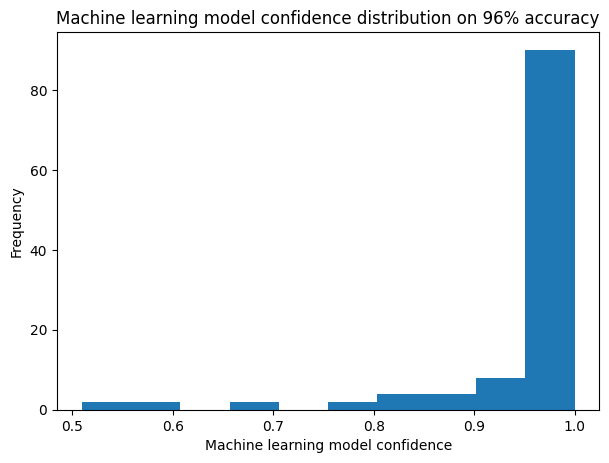

In [ ]:
# Confidence distributation of cluster 16
cluster_confidence = np.amax(_model_probs[0], axis=1)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(cluster_confidence, bins=10)
plt.gca().set(title='Machine learning model confidence distribution on 96% accuracy', xlabel='Machine learning model confidence', ylabel='Frequency');

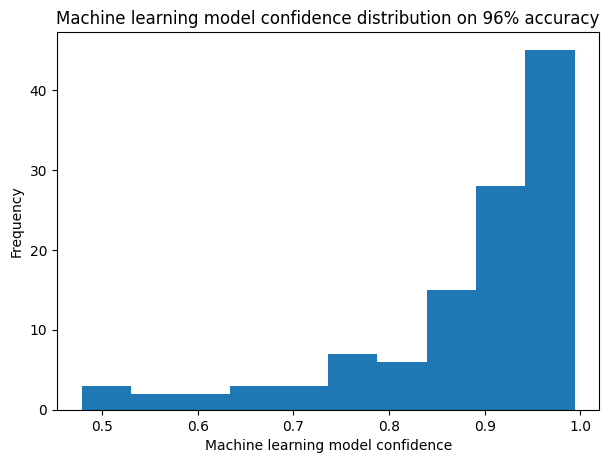

In [ ]:
# After applying temperature scaling
cluster_calibrated_probs = np.array(_model_probs[0]) ** (1. / _T[0])  # Temper
cluster_calibrated_probs /= np.sum(cluster_calibrated_probs, axis=1, keepdims=True)

# Confidence distributation of cluster 16
cluster_confidence = np.amax(cluster_calibrated_probs, axis=1)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(cluster_confidence, bins=10)
plt.gca().set(title='Machine learning model confidence distribution on 96% accuracy', xlabel='Machine learning model confidence', ylabel='Frequency');

In [ ]:
clipped_model_probs = np.clip(model_probs_te, eps, 1)
model_logits = np.log(clipped_model_probs)
labels = kmeans.predict(model_logits)

In [ ]:
for i in range(model_probs_te.shape[0]):
    model_probs_te[i] = model_probs_te[i] ** (1. / _T[labels[i]])

model_probs_te /= np.sum(model_probs_te, axis=1, keepdims=True)  # Normalize

In [ ]:
# Human or model
for human_cost in tqdm(range(1, 100)):
    for miss_cost in range(human_cost+1, 100):

        human_refered = 0
        model_refered = 0

        Y_pred = np.argmax(model_probs_te, axis=1)
        y_comb = []
        for i in range(labels.shape[0]):
            P_X = miss_cost * (1 - model_probs_te[i][Y_pred[i]])
            if(human_cost <= P_X):
                human_refered += 1
                y_comb.append(y_h_te[i])
            else:
                model_refered += 1
                y_comb.append(Y_pred[i])
        
        acc = np.mean(y_comb == y_true_te)
        if acc >= .96:
            print("{}, {}, {}, {}, {}".format(human_cost, miss_cost, acc, human_refered, model_refered))

In [ ]:
conf_h = 1. * confusion_matrix(y_true, y_h, labels=np.arange(10))
# Swap so entry [i, j] is #(h = i and Y = j)
conf_h = conf_h.T
conf_h = np.clip(conf_h, 1e-50, None)
normalizer = np.sum(conf_h, axis=0, keepdims=True)
# Normalize columns so entry [i, j] is P(h = i | Y = j)
conf_h /= normalizer

y_comb = np.empty((3000, 10))
Y_pred = np.argmax(model_probs_te, axis=1)

# Human or model
for human_cost in tqdm(range(2, 100)):
    for miss_cost in range(human_cost, 100):
        human_refered = 0
        model_refered = 0

        for i in range(3000):
            P_X = miss_cost * (1 - model_probs_te[i][Y_pred[i]])
            if(human_cost <= P_X):
                y_comb[i] = model_probs_te[i] * conf_h[y_h_te[i]]
                human_refered += 1
            else:
                y_comb[i] = model_probs_te[i]
                model_refered += 1

            if np.allclose(y_comb[i], 0):  # Handle zero rows
                y_comb[i] = np.ones(10) * (1./10)

        acc = np.mean(np.argmax(y_comb, axis=1) == y_true_te)
        if acc >= .979:
            print("{}, {}, {}, {}, {}".format(human_cost, miss_cost, acc, human_refered, model_refered))

In [ ]:
y_comb = np.empty((3000, 10))
Y_pred = np.argmax(model_probs_te, axis=1)

# Human or model
for human_cost in tqdm(range(2, 100)):
    for miss_cost in range(human_cost, 100):
        human_refered = 0
        model_refered = 0

        for i in range(3000):
            P_X = miss_cost * (1 - model_probs_te[i][Y_pred[i]])
            if(human_cost <= P_X):
                y_comb[i] = model_probs_te[i] * _conf_h[labels[i]][y_h_te[i]]
                human_refered += 1
            else:
                y_comb[i] = model_probs_te[i]
                model_refered += 1

            if np.allclose(y_comb[i], 0):  # Handle zero rows
                y_comb[i] = np.ones(10) * (1./10)

        acc = np.mean(np.argmax(y_comb, axis=1) == y_true_te)
        if acc >= .971:
            print("{}, {}, {}, {}, {}".format(human_cost, miss_cost, acc, human_refered, model_refered))

In [ ]:
# import pandas as pd

# df1 = pd.read_csv('/content/output/r_low_acc_accuracy.csv')
# df2 = pd.read_csv('/content/output/resnet-110_accuracy.csv')
# df3 = pd.read_csv('/content/output/preresnet-110_accuracy.csv')
# df4 = pd.read_csv('/content/output/densenet-bc-L190-k40_accuracy.csv')

In [ ]:
# name = [];
# prices = [];
# r1 = df2.mean(axis=0)
# for key in r1.keys():
#     if(r1[key] < 1):
#         name.append(key)
#         prices.append(100 - r1[key] * 100)

# name = np.array(name)
# prices = np.array(prices)

In [ ]:
# r1.keys()

In [ ]:
# name1 = ['Human Error', 'Model Error', 'Combined Error']
# prices1 = [100 - r1['human']*100, 100 - r1['model']*100, 100 - r1['Combined accuracy']*100]

# name2 = ['Human refered', 'Model refered']
# prices2 = [r1['Human refered'], r1['Model refered']]

In [ ]:

# import pandas as pd
# from matplotlib import pyplot as plt

# # Figure Size
# fig, ax = plt.subplots(figsize =(5, 4))
 
# # Horizontal Bar Plot
# ax.barh(name2, prices2)
 
# # Remove axes splines
# for s in ['top', 'bottom', 'left', 'right']:
#     ax.spines[s].set_visible(False)
# # Remove x, y Ticks
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
 
# # Add padding between axes and labels
# ax.xaxis.set_tick_params(pad = 5)
# ax.yaxis.set_tick_params(pad = 10)
 
# # Add x, y gridlines
# ax.grid(b = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)
 
# # Show top values
# ax.invert_yaxis()
 
# # Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')
 
# # # Add Plot Title
# # ax.set_title('Error Rate(%) on CIFAR-10H dataset',
# #              loc ='left', )
 
# # # Add Text watermark
# # fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,
# #          color ='grey', ha ='right', va ='bottom',
# #          alpha = 0.7)
 
# # Show Plot
# plt.show()

In [ ]:
# r4 = df1.mean(axis=0)

In [ ]:
# r4 = df2.mean(axis=0)

In [ ]:
# r4 = df3.mean(axis=0)

In [ ]:
# r4 = df4.mean(axis=0)

In [ ]:
# for keys in r4.keys():
#     if(r4[keys] < 1.0):
#       print("{}, {}".format(keys, r4[keys]*100))
#     else:
#       print("{}, {}".format(keys, r4[keys]))

### Clustering